# Receiver Simulations

Simulating backscatter retrievals up to cloud boundaries. The simulations will include signals for high- and low-gain channels. The flux will follow the theory from 'photon_budget_calculation.ipynb'. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [3]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 840  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 532.18e-9  # [m] laser wavelength

# D = 16  # [in] outer diameter of telescope
# d = 5  # [in] inner diameter of telescope
D = 8  # [in]
d = 1.8  # [in]

dt_TCSPC = 25e-12  # [s] native resolution of TCSPC

# Laser specs
P_L = 35e-3  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM
f_L = 14.3e3  # [Hz] rep rate

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.05  # Beam-splitter low-gain transmittance
T_BS_HG = 0.95  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 2e3, dalt)  # [m] target range

### Molecular Signal

The molecular signal will serve as the background Rayleigh scattering. The aerosol signal (clouds) will follow.

In [4]:
# Calculate Temperature and Pressure
T = T_0 - L/1000*alt  # [K]

C_g = g_0*M_air/R_0/L
P = P_0 * (T/T_0)**C_g  # [mbar]

# Scattering coefficients
beta_mol = 2.938e-32 * P/T * lamb**(-4.0117)  # [m-1 sr-1]
alpha_mol = 8*np.pi/3 * beta_mol  # [m-1]

# Telescope parameters
A = np.pi/4*(D**2-d**2)  # [in^2]
A *= (0.0254**2)  # [m^2] Area

# Geometric overlap
# G = 1  # assumed one at furthest range
# Choose reasonable inverted exponential for asymptotic rise to 1 at some altitude
G_alt = np.arange(min(alt)-500, round(max(alt)-500), dalt)
alpha = 0.05  # Time constant for exponential
G = (1 / (1+np.exp(-alpha*G_alt)))

# Range resolution
dR = c * dt_TCSPC / 2  # [m]

# Number of transmitted photons per shot
N_L = P_L/f_L/h/c*lamb
# N_L = 1.5e-6/h/c*lamb

# Receiver efficiency
eta_LG = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_BS_LG * T_SBF * eta_QE
eta_HG = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_BS_HG * T_SBF * eta_QE

# Background signal
N_B = 0  # number of background photons

# Generate photon-count expectation function

# Lidar equation for molecular backscatter
R = alt  # [m] assume transmitter and receiver are at the surface

trans = np.exp(-np.cumsum(alpha_mol*dR))

N_mol_LG = N_L*beta_mol*dR*A/R**2*trans**2*eta_LG*G + N_B
N_mol_HG = N_L*beta_mol*dR*A/R**2*trans**2*eta_HG*G + N_B

# Account for unexpected missed photons (e.g., poor alignment)
N_mol_LG /= 10
N_mol_HG /= 10

# Remove first term (unreal, 0 km alt)
N_mol_LG[0] = 0
N_mol_HG[0] = 0

N_mol_LG_tot = np.sum(N_mol_LG)
N_mol_HG_tot = np.sum(N_mol_HG)

print('Total low gain photons: {:.2E}'.format(N_mol_LG_tot))
print('Total high gain photons: {:.2E}'.format(N_mol_HG_tot))

Total low gain photons: 7.46E-01
Total high gain photons: 1.42E+01


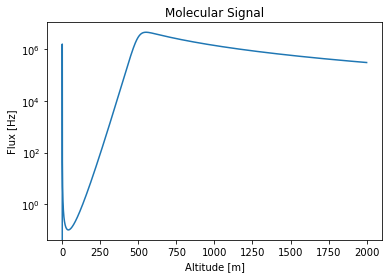

In [5]:
# Molecular (Rayleigh) signal
# Checking how the overlap function looks...

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(alt, N_mol_HG/dt_TCSPC)
# ax.set_ylim([1, 10000])
ax.set_xlabel('Altitude [m]')
ax.set_ylabel('Flux [Hz]')
ax.set_title('Molecular Signal')
plt.show()

# Cloud Signal

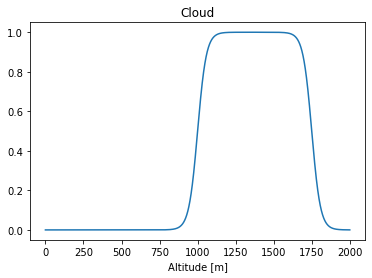

In [6]:
# Add cloud to signal

cloud_bot = 1.0e3  # [m] cloud base
cloud_top = 1.75e3  # [m] cloud top
# cloud_alpha = 0.5  # sharp transition
cloud_alpha = 0.035 # smooth transition
cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))

S = 20  # [sr] lidar ratio
# S = 40  # [sr] try this for rapid extinction
beta_aer = 1e-3  # [m-1 sr-1] singular value for aerosol backscatter

# # Boxcar-function cloud
# cloud = np.zeros(len(alt))
# cloud_idx = np.where((alt>=cloud_bot) & (alt<=cloud_top))[0]
# cloud[cloud_idx] = np.ones(len(cloud_idx))

# Double-sigmoid cloud
cloud = np.ones(len(alt))
cloud *= cloud_sig

beta_aer = beta_aer * cloud  # [m-1 sr-1]
alpha_aer = S * beta_aer  # [m-1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alt, cloud)
ax.set_xlabel('Altitude [m]')
ax.set_title('Cloud')
plt.show()

In [7]:
# Lidar equation for combined molecular and aerosol backscatter
R = alt  # assume transmitter and receiver are at the surface

trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))

N_com_LG = N_L*(beta_mol+beta_aer)*dR*A/R**2*trans**2*eta_LG*G + N_B
N_com_HG = N_L*(beta_mol+beta_aer)*dR*A/R**2*trans**2*eta_HG*G + N_B

# Remove first term (unreal, 0 km alt)
N_com_LG[0] = 0
N_com_HG[0] = 0

# Unaccounted missed photons
N_com_LG /= 10
N_com_HG /= 10

N_com_LG_tot = np.sum(N_com_LG)
N_com_HG_tot = np.sum(N_com_HG)

print('Total low gain photons: {:.2E}'.format(N_com_LG_tot))
print('Total high gain photons: {:.2E}'.format(N_com_HG_tot))

Total low gain photons: 1.18E+01
Total high gain photons: 2.24E+02


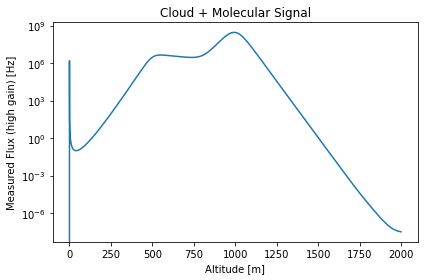

In [8]:
# Check cloud + mol signal

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(R, N_com_HG/dt_TCSPC, '-')
ax.set_xlabel('Altitude [m]')
ax.set_ylabel('Measured Flux (high gain) [Hz]')
ax.set_title('Cloud + Molecular Signal')
# ax.set_ylim([1,1e8])
# ax.set_xlim([750, 1250])
ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Generate simulated returns

Using Matt's code (same one I used for my deadtime experiments), generate simulated measurements using the arrival-rate function generated.

In [11]:
# Parameters for simulation. !!!Make sure to change simulation number for corresponding image!!!

sim_num = 7

use_com = True
time_vary = False
use_hg = False
use_window = True

home = str(Path.home())
save_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Cloud Measurements\Sims\saved_sims'

"""
Using Matthew Hayman's 'photon_count_generator' method in 'sim_deadtime_utils', generate simulated data with
and without deadtime effects.
:param t_sim_max: (float) maximum time for each laser shot [s]
:param dt_sim: (float) resolution settings [s]
:param tD: (float) deadtime [s]
:param Nshot: (int) number of laser shots
:param wrap_deadtime: (bool) set TRUE to wrap deadtime into next shot if detection is close to 't_sim_max'
:param window_bnd: (1x2 float list) time bounds on simulation [s]
:param rho_func: (1xlen(t_sim)) arrival-rate function [Hz]
:return: flight_time, true_flight_time, n_shots, t_det_lst, t_phot_lst
"""

if use_hg:
    N_com = N_com_HG
    eta = eta_HG
else:
    N_com = N_com_LG
    eta = eta_LG

dt_sim = dt_TCSPC  # [s]
if use_com:
    rho_func = N_com / dt_sim  # [Hz] arrival-rate function (flux)
else:
    rho_func = N_mol / dt_sim  # [Hz] arrival-rate function (flux)
    
Nshot = 500
tD = 29.1e-9  # [s] Deadtime interval
wrap_deadtime = False
window_bnd = [250, 1000]  # [m] put bounds on simulation to ignore unnecessary segments of flux profile

In [18]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

# generate the simulated scene time axis
t_sim = R / c * 2  # [s] simulation time
t_sim_bins = np.concatenate((t_sim, t_sim[-1:]+dt_sim))  # simulation time histogram bins
t_sim_bins[0] = 0

# generate the photon arrival rate of the profile
photon_rate_arr = rho_func  # [Hz]

# generate photon counts

# lists of photon arrivals per laser shot
start = time.time()
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = []  # actual photons (no dead time)
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

t_det_last = -100.0  # last photon detection event
if time_vary:
    N_com_agg = np.zeros((len(N_com), Nshot))
    cloud_sig_agg = np.zeros((len(N_com), Nshot))
for n in range(Nshot):
    if time_vary:
        # Change cloud base location
        loc = 20 * np.sin(2*np.pi*n/Nshot)  # [m] vary cloud base sinusoidally
        cloud_bot = 1.00e3 + loc  # [m] cloud base
        cloud_top = 1.75e3 + loc  # [m] cloud top
        cloud_sig = (1 / (1+np.exp(-cloud_alpha*(alt-cloud_bot)))) - (1 / (1+np.exp(-cloud_alpha*(alt-cloud_top))))
        cloud = np.ones(len(alt))
        cloud *= cloud_sig
        cloud_sig_agg[:, n] = cloud_sig

        beta_aer = beta_aer * cloud  # [m-1 sr-1]
        alpha_aer = S * beta_aer  # [m-1]

        trans = np.exp(-np.cumsum((alpha_mol+alpha_aer)*dR))
        N_com = N_L*(beta_mol+beta_aer)*dR*A/R**2*trans**2*eta*G + N_B
        N_com[0] = 0
        N_com_agg[:, n] = N_com
        
        rho_func = N_com / dt_TCSPC  # [Hz]
        
        photon_rate_arr = rho_func  # [Hz]
        
    if use_window:
        idx_min = np.argmin(np.abs(t_sim_bins*c/2 - window_bnd[0]))
        idx_max = np.argmin(np.abs(t_sim_bins*c/2 - window_bnd[1]))
        t_sim_bins = t_sim_bins[idx_min:idx_max+1]
        photon_rate_arr = photon_rate_arr[idx_min:idx_max]
#         print(photon_rate_arr)
    
    # simulate a laser shot
    ptime, ctime = sim.photon_count_generator(t_sim_bins, photon_rate_arr, tau_d_flt=tD, last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]

    ctime /= dt_sim  # convert from s to clock counts since sync event
    ptime /= dt_sim  # convert from s to clock counts since sync event

    for i in range(len(ctime)):
        det_events.append(ctime[i])  # detection time tags
        det_sync_idx.append(n)
    for i in range(len(ptime)):
        phot_events.append(ptime[i])  # photon time tags
        phot_sync_idx.append(n)

print('Time elapsed: {} s'.format(time.time()-start))

det_idx = np.arange(len(det_events))
phot_idx = np.arange(len(phot_events))

time_tag_index = det_idx
true_time_tag_index = phot_idx
sync_index = sync_idx
time_tag = det_events
true_time_tag = phot_events
time_tag_sync_index = det_sync_idx
true_time_tag_sync_index = phot_sync_idx

# Save simulated data to netCDF
sim_data = xr.Dataset(
    data_vars=dict(
        time_tag=(['time_tag_index'], time_tag),
        time_tag_sync_index=(['time_tag_index'], time_tag_sync_index),
        true_time_tag=(['true_time_tag_index'], true_time_tag),
        true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index),
        photon_rate_arr=photon_rate_arr,
        dt_sim=dt_sim,
        dtime=tD,
        t_sim_bins=t_sim_bins
    ),
    coords=dict(
        sync_index=(['sync_index'], sync_index)
    )
)

fname = r'\simnum_{}_nshot{:.2E}_useHG{}.nc'.format(sim_num, Nshot, use_hg)
sim_data.to_netcdf(save_dir+fname)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
tof = (np.array(det_events)*dt_sim)
bin_avg = 1000  # integration factor (increase bin sizes)

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
n, bins = np.histogram((np.array(phot_events)*dt_sim), bins=t_sim_bins[::bin_avg])
binwidth = np.diff(bins)[0]
N = n / binwidth / Nshot  # [Hz]
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='r', alpha=0.75, label='Actual')

tof = (np.array(det_events)*dt_sim)
n, bins = np.histogram(tof, bins=t_sim_bins[::bin_avg])
N = n / binwidth / Nshot  # [Hz] Scaling counts to arrival rate
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='b', alpha=0.75, label='Measured')
if use_com:
    if time_vary:
        ax.plot(t_sim*c/2, np.mean(N_com_agg, axis=1)/dt_TCSPC, 'r--', alpha=0.35, label='Truth (mean)')
        ax.plot(t_sim*c/2, N_com_agg[:, ::100]/dt_TCSPC)
    else:
        ax.plot(t_sim*c/2, N_com/dt_TCSPC, 'k--', alpha=0.6, label='Truth')
else:
    ax.plot(t_sim*c/2, N_mol/dt_TCSPC, 'r--', alpha=0.5, label='Truth')
ax.set_ylabel('Flux [Hz]')
ax.set_xlabel('Altitude [m]')
ax.set_title('Simulated Measurements of Cloud Edge')
ax.set_yscale('log')
# ax.set_xlim([250, 1400])
ax.set_ylim([1e4, 1e9])
plt.tight_layout()
plt.legend()
plt.show()
